In [1]:
import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))

macOS-14.4.1-arm64-arm-64bit


In [3]:
pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.0/227.0 MB 2.0 MB/s eta 0:00:0000:0100:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 2.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 2.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 2.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 1.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.8/389.8 kB 2.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 2.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 1.9 MB/s

In [15]:
import tensorflow as tf
tf.random.set_seed(73)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;    
print("Tensorflow version " + tf.__version__)

zsh:1: command not found: nvidia-smi
Tensorflow version 2.16.1


In [16]:
MyDrive = '/kaggle/working'
PROJECT_DIR = './Downloads/violencedataset'

## **Preprocessing**
+ **Getting frames form video**
+ **some image argumentations**

In [17]:
pip install imgaug

Note: you may need to restart the kernel to use updated packages.


In [18]:
import cv2
import os
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

IMG_SIZE = 128
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    
    import math
    rate = math.floor(vidcap.get(3))
    count = 0
    
    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()
        
        if success:
            # skipping frames to avoid duplications 
            if (ID % 7 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))
                
                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)
                
                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)
                
            count += 1
        else:
            break
    
    vidcap.release()
    
    return ImageFrames

In [19]:
%%time
from tqdm import tqdm

VideoDataDir = "./violencedataset/Real Life Violence Dataset"
print('we have \n{} Violence videos \n{} NonViolence videos'.format(
              len(os.listdir(VideoDataDir + '/Violence')), 
              len(os.listdir(VideoDataDir + '/NonViolence'))))

X_original = []
y_original = []

print('i choose 700 videos out of 2000, cuz of memory issue')
CLASSES = ["NonViolence", "Violence"]
#700 <- 350 + 350

for category in os.listdir(VideoDataDir):
    path = os.path.join(VideoDataDir, category)
    class_num = CLASSES.index(category)
    for i, video in enumerate(tqdm(os.listdir(path)[0:152])):
        frames = video_to_frames(path + '/' + video)
        for j, frame in enumerate(frames):
            X_original.append(frame)
            y_original.append(class_num)

we have 
153 Violence videos 
153 NonViolence videos
i choose 700 videos out of 2000, cuz of memory issue


100%|██████████| 152/152 [01:17<00:00,  1.97it/s]

CPU times: user 7min 47s, sys: 20.5 s, total: 8min 8s
Wall time: 2min 15s


In [7]:
import numpy as np
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

13979

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

## **Model Training**

In [9]:
!pip install imutils
clear_output()

In [11]:
import cv2
import os
import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")

import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt


In [12]:
epochs = 50

from keras import regularizers
kernel_regularizer = regularizers.l2(0.0001)

from keras.applications.mobilenet_v2 import MobileNetV2

def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = MobileNetV2(pooling='avg',
                            include_top=False, 
                            input_tensor=input_tensor)
    
    headModel = baseModel.output   
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=["accuracy"])

    return model

if TPU_INIT:
    with tpu_strategy.scope():
        model = load_layers()
else:
    model = load_layers()

model.summary()



9406464/9406464 [==============================] - 0s 0us/step
Compiling model...

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_re

In [14]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 4

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [15]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)

PROJECT_DIR = MyDrive + '/RiskDetection'

lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

os.system('rm -rf ./logs/')

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

if TPU_INIT:
    callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

In [16]:
print('Training head...')
#model.load_weights('./Model_Weights.h5')

history = model.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

print('\nRestoring best Weights for MobileNetV2')
model.load_weights(checkpoint_filepath)

Training head...
Epoch 1/50


2447/2447 [==============================] - ETA: 0s - loss: 0.6979 - accuracy: 0.6077
Epoch 1: val_loss improved from inf to 0.59566, saving model to ModelWeights.h5
2447/2447 [==============================] - 1119s 450ms/step - loss: 0.6979 - accuracy: 0.6077 - val_loss: 0.5957 - val_accuracy: 0.6919 - lr: 1.0000e-05
Epoch 2/50
2447/2447 [==============================] - ETA: 0s - loss: 0.4942 - accuracy: 0.7638
Epoch 2: val_loss improved from 0.59566 to 0.43508, saving model to ModelWeights.h5
2447/2447 [==============================] - 251s 103ms/step - loss: 0.4942 - accuracy: 0.7638 - val_loss: 0.4351 - val_accuracy: 0.8059 - lr: 1.8000e-05
Epoch 3/50
2446/2447 [============================>.] - ETA: 0s - loss: 0.3725 - accuracy: 0.8420
Epoch 3: val_loss improved from 0.43508 to 0.34285, saving model to ModelWeights.h5
2447/2447 [==============================] - 207s 85ms/step - loss: 0.3725 - accuracy: 0.8420 - val_loss: 0.3429 - val_accuracy: 0

------------------------------------------------------------------------------------------
Best Epochs:  49
Accuracy on train: 0.9587123394012451 	Loss on train: 0.12337636947631836
Accuracy on test: 0.947782576084137 	Loss on test: 0.15480230748653412


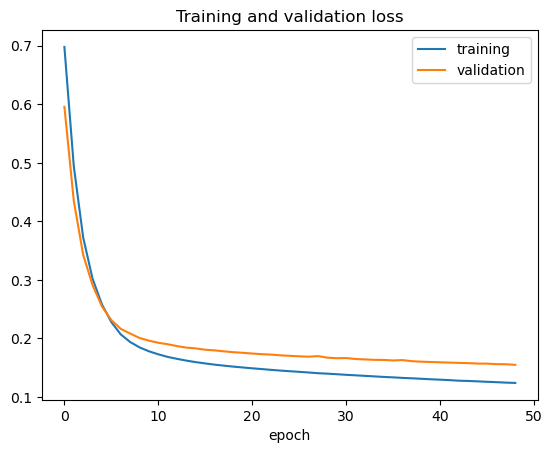

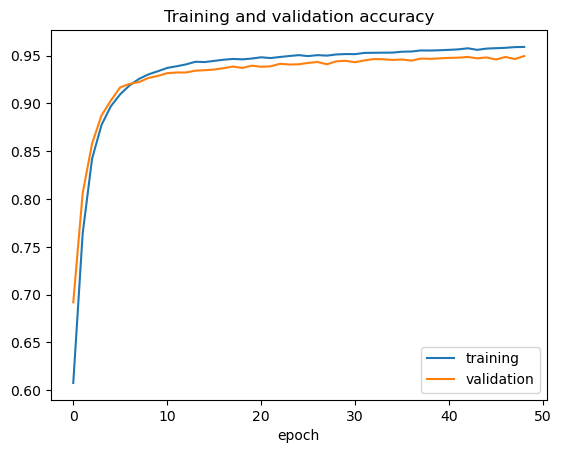

------------------------------------------------------------------------------------------


In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plot = '{}.png'.format(item)
    plt.savefig(plot)  # Save the plot as PNG
    plt.show()

def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i
                
def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)

# Assuming `model` and `history` are defined elsewhere in your code
model_summary(model, history)


------------------------------------------------------------------------------------------
Best Epochs:  49
Accuracy on train: 0.9587123394012451 	Loss on train: 0.12337636947631836
Accuracy on test: 0.947782576084137 	Loss on test: 0.15480230748653412


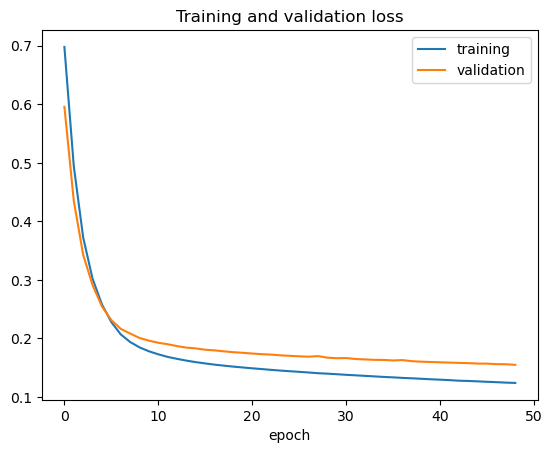

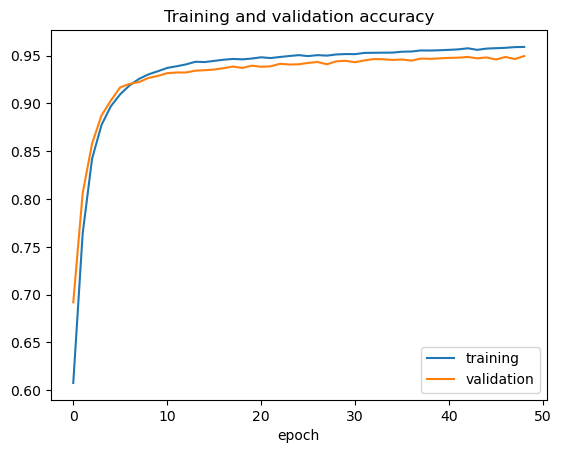

------------------------------------------------------------------------------------------


In [41]:
model_summary(model, history)

## **Evaluation on test set**

In [35]:
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...
132/132 [==============================] - 19s 144ms/step


In [21]:
pip install --upgrade scikit-learn

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/7b/0e/25d6b5678ed3c7e12bc94d047d0e9492e89cc78b7ea0034ac0f1cf2ff304/scikit_learn-1.4.1.post1-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.6 MB 435.7 kB/s eta 0:00:25
   - -------------------------------------- 0.3/10.6 MB 3.4 MB/s eta 0:00:04
   ------ --------------------------------- 1.7/10.6 MB 10.8 MB/s eta 0:00:01
   ----------- ---------------------------- 3.0/10.6 MB 16.2 MB/s eta 0:00:01
   ----------------- ---------------------- 4.5/10.6 MB 19.3 MB/s eta 0:00:01
   ---------------------- ----------------- 6.1/10.6 MB 21.7 MB/s eta 0:00:01
   -----------------

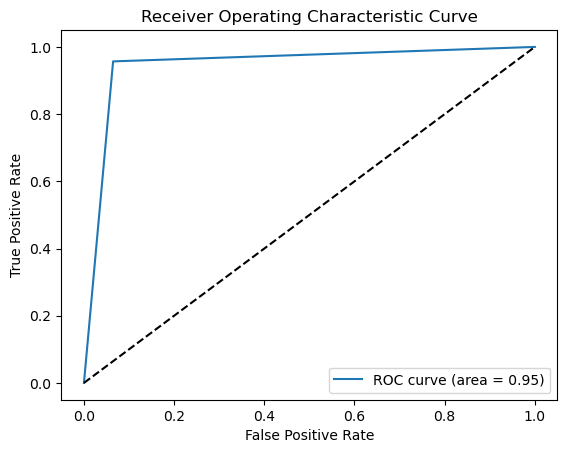

> Correct Predictions: 3975
> Wrong Predictions: 219


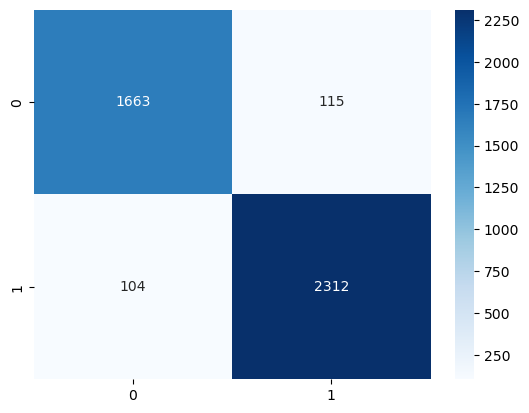

              precision    recall  f1-score   support

 NonViolence       0.94      0.94      0.94      1778
    Violence       0.95      0.96      0.95      2416

    accuracy                           0.95      4194
   macro avg       0.95      0.95      0.95      4194
weighted avg       0.95      0.95      0.95      4194



In [39]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Assuming preds contains the predicted probabilities or scores for the positive class
fpr, tpr, thresholds = roc_curve(y_test, preds)
auc_score = roc_auc_score(y_test, preds)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')  # Save ROC curve plot as PNG
plt.show()

# Confusion matrix and classification report
corr_pred = metrics.confusion_matrix(y_test, preds)

n_correct = int((corr_pred[0][0] + corr_pred[1][1]))
print('> Correct Predictions:', n_correct)
n_wrongs = int((corr_pred[0][1] + (corr_pred[1][0])))
print('> Wrong Predictions:', n_wrongs)

sns.heatmap(corr_pred, annot=True, fmt="d", cmap="Blues")
plt.savefig('confusion_matrix.png')  # Save confusion matrix plot as PNG
plt.show()

print(metrics.classification_report(y_test, preds, target_names=["NonViolence", "Violence"]))


In [38]:
args_model = "modelnew.h5"
model.save(args_model)

C:\Users\Abdo-983\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
